## Example 1: Nonconvex Minimax Problems without Constraints.
We consider the following possibly nonconvex-nonconcave minimax problem:
\begin{equation}
\min_{u \in \mathbb{R}^{p_1}}\max_{v\in\mathbb{R}^{p_2}}\Big\{ \mathcal{L}(u,v) = f(u) + \frac{1}{n}\sum_{i=1}^n\big[u^{\top}A_iu + u^{\top}L_iv - v^{\top}B_iv + b_i^{\top}u - c_i^{\top}v\big] - g(v) \Big\},
\end{equation}
where $A_i \in\mathbb{R}^{p_1\times p_1}$ and $B_i \in \mathbb{R}^{p_2\times p_2}$ are symmetric matrices, $b_i \in\mathbb{R}^{p_1}$, $c_i \in\mathbb{R}^{p_2}$, and $L_i \in \mathbb{R}^{p_1\times p_2}$ is a given matrix.
Here, we add two terms $f(u)$ and $g(v)$ to possibly handle constraints or regularizers associated with $u$ and $v$, respectively.

In this experiment, we consider the case $f = 0$ and $g=0$, without constraints. The optimality condition of the minimax problem reduces to $G(x) = 0$ as a linear equation.

In [32]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import random
import scipy as sci
import solvers.ne_solvers as solver
import solvers.ame_solvers as acc_solver

## Linear Operator $G(x)$
Define the perator $G(x) := [Au + Lv + b, -L^{\top}u + Bv + c]$ for our experiments, where $A := \frac{1}{n}\sum_{i=1}^nA_i$, $B := \frac{1}{n}\sum_{i=1}^nB_i$, $L := \frac{1}{n}\sum_{i=1}^nL_i$, $b := \frac{1}{n}\sum_{i=1}^nb_i$, and $c := \frac{1}{n}\sum_{i=1}^nc_i$.

In [33]:
def G_op_eval(data, x, mb_id, mb_size):
    """
    -- Define the operator G for our methods
    -- Args: data, x=x(k), mb_id=the indices of minibatch-size, mb_size=the size of mini-batch.
    -- Returns: G(x).
    """
    K = data.get("K")
    b = data.get("b")
    return np.mean([K[i].dot(x) + b[i] for i in mb_id], axis=0)

def Gb_op_eval(data, x, mb_id, mb_size):
    """
    -- Define the operator G and also output the output components.
    """
    K   = data.get("K")
    b   = data.get("b")
    y_b = [K[i].dot(x) + b[i] for i in mb_id]
    return np.mean(y_b, axis=0), y_b

## Synthetic Data
We generate a synthetic data to test all algorithms. 

In [34]:
## the size of data
n, p = 5000, 100
LB_val = -0.00

# generate a symmetric matrix.
p1    = int(p/2)
p2    = p-p1
K, b  = [], []
K_sum = []
for i in range(n):
    # Generate KKT matrix
    D1    = np.maximum(np.diag(np.random.randn(p1)), LB_val)
    Q1, _ = la.qr(np.random.randn(p1, p1))
    Ai    = np.matmul(np.matmul(Q1, D1), Q1.T)
    
    D2    = np.maximum(np.diag(np.random.randn(p2)), LB_val)
    #D2   = D2/np.sum(D2, axis=1, keepdims=True)
    Q2, _ = la.qr(np.random.randn(p2, p2))
    Bi    = np.matmul(np.matmul(Q2, D2), Q2.T)
    
    Li    = np.random.randn(p1,p2)
    #Li   = Li/np.sum(Li, axis=1, keepdims=True)
    
    Ki    = np.block([[Ai,  Li], [-Li, Bi]])
    ##Ki  = Ki/np.sum(Ki, axis=1, keepdims=True)
    ##Ki  = Ki/la.norm(Ki, ord=2)
   
    # generate bi.
    bi    = np.random.randn(p)
    ## bi = bi/np.sum(bi)
    
    K.append(Ki)
    b.append(bi)
    if i==0:
        K_sum = Ki
    else:
        K_sum = K_sum + Ki
K_sum = (1/n)*K_sum

# compute the Lipschitz constant.
Lips = la.norm(K_sum, ord=2)    
print("The Lipschitz constant:", Lips)

# creat the input data
my_data = dict({"K": K, "b": b, "n": n, "p": p, "L": Lips})

## general an initial point.
x0 = np.random.randn(p)

The Lipschitz constant: 0.5296949196944579


## Set Default Parameters

In [35]:
## set default parameters
def_gamma        = 0.75
def_lr           = 0.5
def_max_iters    = 10000
def_tol          = 1e-20
def_n_max_epochs = 100
def_mb_size      = int(n**0.67)
my_is_term       = False  ## using termination condition or not.
my_verbose       = 1


## Test all algorithms one time
Now, we test all the algorithms implmented above.

In [36]:
## All output is empty
output_all       = []

## Optimistic gradient method
my_max_iters1 = def_n_max_epochs
my_lr1        = 0.5/my_data.get("L")
print("Learning rate: ", my_lr1)
output1       = solver.OG(my_data, G_op_eval, x0, gamma=0.5, eta=my_lr1,\
                         verbose=my_verbose, n_max_iters=my_max_iters1,\
                         tol=def_tol, is_term = my_is_term)
print("Solver status (OG):", output1["message"])
output_all.append(output1)

## Accelerated optimistic gradient method
my_max_iters2 = def_n_max_epochs
my_r_shift2   = 10.0
my_lr2        = 0.5/my_data.get("L")
print("Learning rate: ", my_lr2)
output2       = acc_solver.AOG(my_data, G_op_eval, x0, beta=my_lr2, r_shift = my_r_shift2, \
                          verbose=my_verbose, n_max_iters=my_max_iters2,\
                          tol=def_tol, is_term = my_is_term)
print("Solver status (AOG):", output2["message"])
output_all.append(output2)

## SAGA-Root-Finding method from Davis' paper
my_mb_size3 = int(0.5*n**0.67) # default
my_lr3      = 0.25/my_data.get("L")
print("Learning rate: ", my_lr3)
output3     = solver.SagaRF(my_data, G_op_eval, Gb_op_eval, x0, mb_size=my_mb_size3, \
                            eta=my_lr3, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                            tol=def_tol, is_term = my_is_term)
print("Solver status (SagaRF):", output3["message"])
output_all.append(output3)

## SVRG Forward-Reflected-Backward Splitting Method
my_prob4    = 1.0/(n**0.33)    # default value
my_mb_size4 = int(0.5*n**0.67) # default value
# Theoretical learning rate
my_lr4      = 5.0 * 0.99*(1 - np.sqrt(1-my_prob4))/(2.0*my_data.get("L"))
print("Learning rate: ", my_lr4)
output4     = solver.VrFRBS(my_data, G_op_eval, x0, mb_size=my_mb_size4, prob=my_prob4, \
                           eta=my_lr4, verbose=my_verbose, n_epochs=def_n_max_epochs, \
                           tol=def_tol, is_term = my_is_term)
print("Solver status (VrFRBS):", output4["message"])
output_all.append(output4)

## SVRG Extragradient method
my_prob5    = np.minimum(1.0/(n**0.33), 0.99) # default value
my_mb_size5 = int(0.5*n**0.67) # default value
my_alpha5   = 1 - my_prob5 
my_lr5      = 0.99 * np.sqrt(1-my_alpha5)/my_data.get("L")
print("Learning rate: ", my_lr5)
output5     = solver.VrEG(my_data, G_op_eval, x0, mb_size=my_mb_size5, prob=my_prob5, \
                          eta=my_lr5, alpha=my_alpha5, verbose=my_verbose, n_epochs=def_n_max_epochs,\
                          tol=def_tol, is_term = my_is_term)
print("Solver status (VrEG):", output5["message"])
output_all.append(output5)

## Accelerated SVRG-Forward Reflected method
my_mb_size6 = int(0.5*n**0.67) # default
my_prob6    = 1.0/(n**0.33) # default
my_lr6      = 0.15/my_data.get("L")
my_shift6   = 20.0
print("Learning rate: ", my_lr6)
output6     = acc_solver.SvrgAcFR(my_data, G_op_eval, x0, mb_size=my_mb_size6, prob=my_prob6, \
                             beta=my_lr6, verbose=my_verbose, r_shift = my_shift6, \
                             n_epochs=def_n_max_epochs, tol=def_tol, is_term = my_is_term)
print("Solver status (SvrgAcFR):", output6["message"])
output_all.append(output6)

"""
## Accelerated SVRG-Forward Reflected method - Strongly monotone case
my_mb_size7  = int(0.5*n**0.67) # default
my_prob7     = 1.0/(n**0.33) # default
my_lr7       = 0.15/my_data.get("L")
my_shift7    = 20.0
my_s_shift7  = 25
my_str_mono7 = True
print("Learning rate: ", my_lr7)
output7      = acc_solver.SvrgAcFR(my_data, G_op_eval, x0, mb_size=my_mb_size7, prob=my_prob7, \
                                  beta=my_lr7, verbose=my_verbose, r_shift = my_shift7, \
                                  s_shift = my_s_shift7, is_strong_mono = my_str_mono7, \
                                  n_epochs=def_n_max_epochs, tol=def_tol, is_term = my_is_term)
print("Solver status (smono-SvrgAcFR):", output7["message"])
output_all.append(output7)
"""

## Accelerated SAGA-Forward Reflected method
my_mb_size8 = int(0.5*n**0.67) # default
my_lr8      = 0.25/my_data.get("L")
my_shift8   = 20.0
print("Learning rate: ", my_lr8)
output8     = acc_solver.SagaAcFR(my_data, G_op_eval, Gb_op_eval, x0, mb_size=my_mb_size8, \
                             beta=my_lr8, verbose=my_verbose, r_shift = my_shift8, \
                             n_epochs=def_n_max_epochs, tol=def_tol, is_term = my_is_term)
print("Solver status (SagaAcFR):", output8["message"])
output_all.append(output8)


Learning rate:  0.9439395799537086
Solver: Optimistic Gradient Method for Equations ...
  Epoch  |     Error     |   ||G(x)||    
 ------------------------------------------
   0     |   1.777e+00   |   1.000e+00   |
   1     |   1.100e+00   |   8.071e-01   |
   2     |   1.018e+00   |   6.897e-01   |
   3     |   8.438e-01   |   5.815e-01   |
   4     |   7.204e-01   |   4.930e-01   |
   5     |   6.116e-01   |   4.181e-01   |
   6     |   5.209e-01   |   3.553e-01   |
   7     |   4.442e-01   |   3.023e-01   |
   8     |   3.793e-01   |   2.576e-01   |
   9     |   3.243e-01   |   2.198e-01   |
   10    |   2.777e-01   |   1.879e-01   |
   11    |   2.381e-01   |   1.608e-01   |
   12    |   2.044e-01   |   1.378e-01   |
   13    |   1.757e-01   |   1.182e-01   |
   14    |   1.512e-01   |   1.016e-01   |
   15    |   1.303e-01   |   8.737e-02   |
   16    |   1.124e-01   |   7.524e-02   |
   17    |   9.701e-02   |   6.486e-02   |
   18    |   8.382e-02   |   5.597e-02   |
   19    

## Plot the results of one experiment

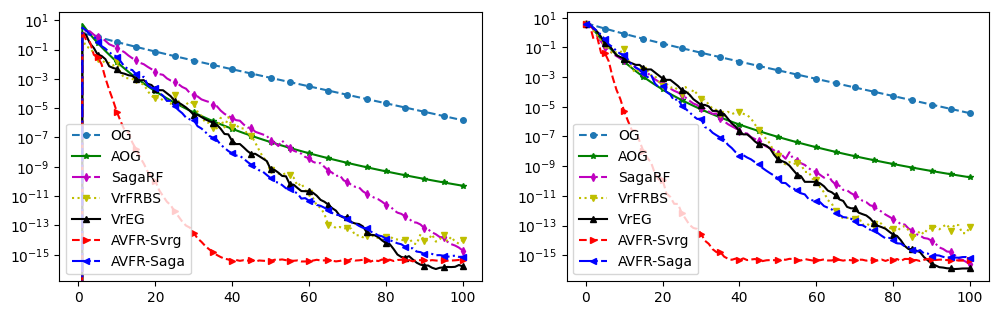

In [39]:
## Number of methods
hist, it_plt, error, op_norm = [], [], [], []
for i in range(len(output_all)):
    hist   = output_all[i]["epoch_hist"]
    it_plt.append( [h.get("epoch") for h in hist] )
    error.append( [h.get("error") for h in hist] )
    op_norm.append( [h.get("op_norm") for h in hist] )

## This is for plottings
#alg_name = ['OG', 'AOG', 'SagaRF', 'VrFRBS', 'VrEG', 'AVFR-Svrg', 'AVFR-Svrg2', 'AVFR-Saga']
alg_name = ['OG', 'AOG', 'SagaRF', 'VrFRBS', 'VrEG', 'AVFR-Svrg',  'AVFR-Saga']
colors   = ['C0', 'g', 'm', 'y', 'k', 'r', 'b', 'C1']
line_styles = ['--', '-', '-.', ':', '-', '--', '-.', '-', '--']
my_markers = ['o', '*', 'd', 'v', '^', '>', '<', 's', 'o']


## Now we plot the results.
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))
for i in range(len(output_all)):
    axs[0].semilogy(it_plt[i], error[i], color=colors[i], linestyle=line_styles[i],\
                    marker = my_markers[i], markersize=4, markevery=5, label=alg_name[i])
    axs[1].semilogy(it_plt[i], op_norm[i], color=colors[i], linestyle=line_styles[i],\
                    marker = my_markers[i], markersize=4, markevery=5, label=alg_name[i])
axs[0].legend()
axs[1].legend()

plt.show()
